In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
import PIL
import pathlib

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!cp -rf ../input/tomato-palnts/plant-village/plant-village/PlantVillage/Tomato_Early_blight ./Tomato_Early_blight  

In [4]:
!cp -rf ../input/tomato-palnts/plant-village/plant-village/PlantVillage/Tomato_Bacterial_spot ./Tomato_Bacterial_spot

In [5]:
!cp -rf ../input/tomato-palnts/plant-village/plant-village/PlantVillage/Tomato_Late_blight ./Tomato_Late_blight


In [6]:
!cp -rf ../input/tomato-palnts/plant-village/plant-village/PlantVillage/Tomato_healthy ./Tomato_healthy


In [7]:
CURRENT_DIR = os.getcwd()
dataset = pathlib.Path(CURRENT_DIR)
print(dataset)

/kaggle/working


In [8]:
healthy_leaf = len(list(dataset.glob('Tomato_healthy/*')))
unhealthy_leaf = len(list(dataset.glob('Tomato_Late_blight/*')))
unhealthy1_leaf = len(list(dataset.glob('Tomato_Bacterial_spot/*')))
unhealthy2_leaf = len(list(dataset.glob('Tomato_Early_blight /*')))
print(f'Number of Tomato_healthy leaf: {healthy_leaf}')
print(f'Number of Tomato_unhealty leaf: {unhealthy_leaf,unhealthy1_leaf,unhealthy2_leaf}')

Number of Tomato_healthy leaf: 1591
Number of Tomato_unhealty leaf: (1909, 2127, 0)


In [10]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCH=30 
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    directory=dataset,
     batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

Found 6627 files belonging to 5 classes.
Using 5302 files for training.


In [12]:
# Validation dataset
valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory=dataset,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
)

Found 6627 files belonging to 5 classes.
Using 1325 files for validation.


In [13]:
class_names= train_ds.class_names
class_names

['.virtual_documents',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_healthy']

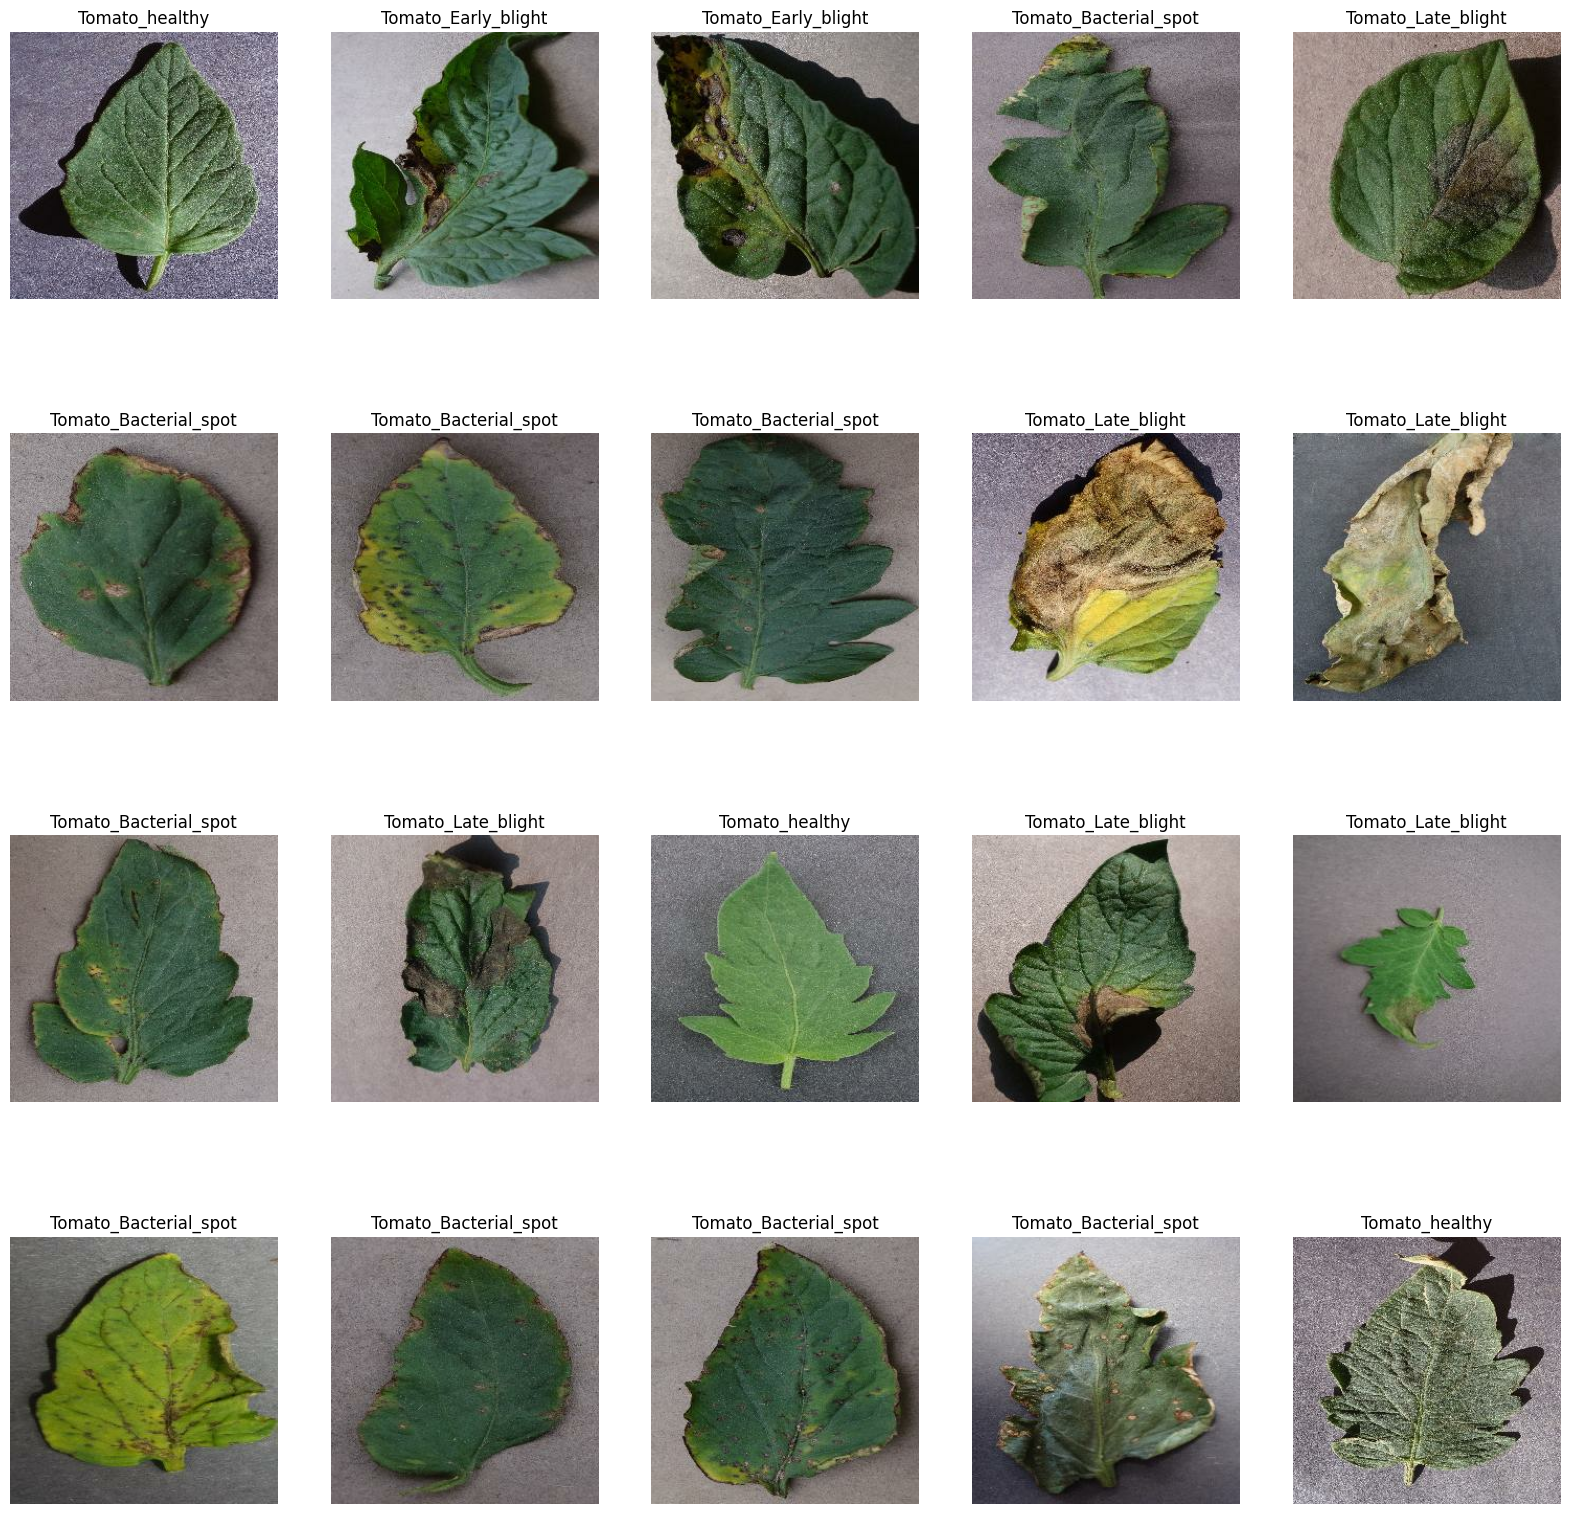

In [16]:
plt.figure(figsize=(20,20))
for image_batch,label_batch in train_ds.take(1):
    for i in range(20):
        plt.subplot(4,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

valid_ds=valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

In [18]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=10
model=Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2,)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')])

model.build(input_shape=input_shape)
    

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    patience=5,
    min_delta=0.02
)

In [22]:
history=model.fit(
    train_ds,
    epochs=30,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=valid_ds
)

Epoch 1/30
166/166 [==============================] - 19s 72ms/step - loss: 1.1333 - accuracy: 0.5198 - val_loss: 0.8654 - val_accuracy: 0.6294
Epoch 2/30
166/166 [==============================] - 10s 59ms/step - loss: 0.6879 - accuracy: 0.7267 - val_loss: 0.6082 - val_accuracy: 0.7562
Epoch 3/30
166/166 [==============================] - 10s 59ms/step - loss: 0.4954 - accuracy: 0.8005 - val_loss: 0.5902 - val_accuracy: 0.7925
Epoch 4/30
166/166 [==============================] - 10s 59ms/step - loss: 0.4184 - accuracy: 0.8386 - val_loss: 0.6275 - val_accuracy: 0.7796
Epoch 5/30
166/166 [==============================] - 10s 59ms/step - loss: 0.3683 - accuracy: 0.8629 - val_loss: 0.5671 - val_accuracy: 0.7706
Epoch 6/30
166/166 [==============================] - 10s 59ms/step - loss: 0.3233 - accuracy: 0.8810 - val_loss: 0.3650 - val_accuracy: 0.8709
Epoch 7/30
166/166 [==============================] - 10s 60ms/step - loss: 0.2623 - accuracy: 0.9017 - val_loss: 0.2649 - val_accuracy:

In [23]:
scores=model.evaluate(valid_ds)

42/42 [==============================] - 1s 21ms/step - loss: 0.0982 - accuracy: 0.9623


In [24]:
scores

[0.09821218997240067, 0.9622641801834106]

In [26]:
model.save("my_model.keras")